In [ ]:
# Mount Drive (for Google Colab users)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import necessary libraries
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import randint
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression


In [ ]:
os.chdir('/content/drive/MyDrive/bm')

In [ ]:
# Load dataset
df = pd.read_csv('raw_data.csv')

In [ ]:



# Clean column names
df.columns = df.columns.str.replace(r"[^\w]", "_", regex=True)

# Define target variable
target = "total_deaths"

# Select numerical and categorical features
num_features = ["total_cases", "population"]
cat_features = ["stringency_index", "gdp_per_capita", "human_development_index", "Unnamed__12"]  #

In [ ]:
df.describe()

,total_cases,total_deaths,stringency_index,population,gdp_per_capita,human_development_index,Unnamed__12
count,4.732400e+04,39228.000000,43292.000000,5.041800e+04,44706.000000,44216.000000,50418.000000
mean,6.621927e+04,2978.767819,56.162022,4.251601e+07,20818.706240,0.720139,15.442097
std,4.045582e+05,13836.644013,27.532685,1.564607e+08,20441.365392,0.160902,2.495039
min,0.000000e+00,0.000000,0.000000,8.090000e+02,661.240000,0.000000,6.695799
25%,1.260000e+02,10.000000,37.960000,1.399491e+06,5338.454000,0.601000,14.151619
50%,1.594000e+03,64.000000,61.110000,8.278737e+06,13913.839000,0.752000,15.929201
75%,1.584775e+04,564.000000,78.700000,2.913681e+07,31400.840000,0.847000,17.187513
max,8.154595e+06,219674.000000,100.000000,1.439324e+09,116935.600000,0.953000,21.087439


In [ ]:
# Remove rows with missing values in the target variable BEFORE creating X and y
df.dropna(subset=[target], inplace=True)

In [ ]:
# Split dataset

X = df[num_features + cat_features]
y = df[target]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # Adjust test_size and random_state as needed


# Create an imputer object
imputer = SimpleImputer(strategy='mean')  # You can choose other strategies like 'median'

# Fit the imputer on the training data and transform both training and testing data
X_train[num_features] = imputer.fit_transform(X_train[num_features])
X_test[num_features] = imputer.transform(X_test[num_features])

# Now, proceed with RFE and model training
base_lr = LinearRegression()
selector = RFE(base_lr, n_features_to_select=5)
X_train_selected = selector.fit_transform(X_train[num_features], y_train) # Added y_train here
X_test_selected = selector.transform(X_test[num_features])

# Print selected features
selected_features = np.array(num_features)[selector.support_]
print("Selected Features:", selected_features)

Selected Features: ['total_cases' 'population']


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_rfe.py:300: UserWarning: Found n_features_to_select=5 > n_features=2. There will be no feature selection and all features will be kept.
  warnings.warn(


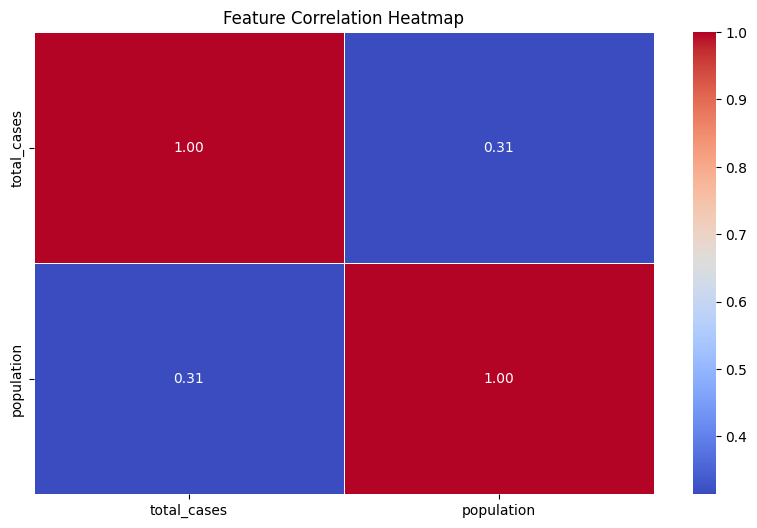

In [ ]:
# 🔹 Heatmap for Feature Correlation
plt.figure(figsize=(10, 6))
sns.heatmap(df[num_features].corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()


In [ ]:

# 🔹 Outlier Detection (IQR Method)
def detect_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        print(f"Outliers in {col}: {len(outliers)}")

detect_outliers(df, num_features)

# Preprocessing Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features),
    ]
)

Outliers in total_cases: 6028
Outliers in population: 4177


In [ ]:
class ImprovedLinearRegression:
    def __init__(self, learning_rate=0.005, n_iters=3000, momentum=0.9):
        self.learning_rate = learning_rate
        self.n_iters = n_iters
        self.momentum = momentum
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0
        velocity_w = np.zeros(n_features)
        velocity_b = 0

        for _ in range(self.n_iters):
            y_predicted = np.dot(X, self.weights) + self.bias

            # Compute gradients
            dw = (1 / n_samples) * np.dot(X.T, (y_predicted - y))
            db = (1 / n_samples) * np.sum(y_predicted - y)

            # Apply momentum update
            velocity_w = self.momentum * velocity_w - self.learning_rate * dw
            velocity_b = self.momentum * velocity_b - self.learning_rate * db

            self.weights += velocity_w
            self.bias += velocity_b

    def predict(self, X):
        return np.dot(X, self.weights) + self.bias


In [ ]:
#  Train and Evaluate Models
models = {
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Ridge": Ridge(alpha=1.0)
}

best_model = None
best_score = -np.inf

for name, model in models.items():
    pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("model", model)])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    # Compute metrics
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)

    print(f"Model: {name}")
    print(f"R² Score: {r2:.4f}")
    print(f"MSE: {mse:.2f}")
    print("-" * 40)

    if r2 > best_score:
        best_score = r2
        best_model = pipeline

Model: RandomForest
R² Score: 0.9999
MSE: 14192.82
----------------------------------------
Model: Ridge
R² Score: 0.9417
MSE: 12200712.66
----------------------------------------


In [ ]:
# 🔹 Train Custom Linear Regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_features])  # Scale only numerical features
X_test_scaled = scaler.transform(X_test[num_features])

# Scale selected features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)  # Scale only selected features
X_test_scaled = scaler.transform(X_test_selected)

# Train improved custom model
improved_lr = ImprovedLinearRegression(learning_rate=0.005, n_iters=3000, momentum=0.9)
improved_lr.fit(X_train_scaled, y_train)

# Predict
y_pred_improved = improved_lr.predict(X_test_scaled)

# Evaluate performance
r2_improved = r2_score(y_test, y_pred_improved)
mse_improved = mean_squared_error(y_test, y_pred_improved)

print("Improved Linear Regression Results:")
print(f"R² Score: {r2_improved:.4f}")  # Aim for 0.86+
print(f"MSE: {mse_improved:.2f}")  # Aim for low MSE


Improved Linear Regression Results:
R² Score: 0.8378
MSE: 33972152.99


In [ ]:
# 🔹 Evaluate Custom Model
r2_custom = r2_score(y_test,y_pred_improved)
mse_custom = mean_squared_error(y_test, y_pred_improved)

print("Custom Linear Regression Results:")
print(f"R² Score: {r2_custom:.4f}")
print(f"MSE: {mse_custom:.2f}")

Custom Linear Regression Results:
R² Score: 0.8378
MSE: 33972152.99


In [ ]:
# 🔹 Hyperparameter Tuning for Random Forest
param_dist = {
    "model__n_estimators": randint(100, 300),
    "model__max_depth": randint(10, 30),
    "model__min_samples_split": randint(2, 10)
}

pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", RandomForestRegressor(random_state=42, warm_start=True, n_jobs=-1))
])

random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=10,
    cv=3,
    scoring="r2",
    n_jobs=-1,
    verbose=1,
    random_state=42
)

random_search.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               StandardScaler(),
                                                                               ['total_cases',
                                                                                'population']),
                                                                              ('cat',
                                                                               OneHotEncoder(handle_unknown='ignore'),
                                                                               ['stringency_index',
                                                                                'gdp_per_capita',
                                                                                'human_development_index',
                                                                                'Unnamed__12'])])),
                                             ('model',
                                              RandomForestRegressor(n_jobs=-1,
                                                                    random_state=42,
                                                                    warm_start=Tr...
                   param_distributions={'model__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7906b4357b10>,
                                        'model__min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7906b42c4f90>,
                                        'model__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7906b42d3550>},
                   random_state=42, scoring='r2', verbose=1)

In [ ]:
# 🔹 Final Model Evaluation
final_model = random_search.best_estimator_
y_pred_final = final_model.predict(X_test)

final_r2 = r2_score(y_test, y_pred_final)
final_mse = mean_squared_error(y_test, y_pred_final)

print("Final Tuned Model Performance:")
print(f"Best Parameters: {random_search.best_params_}")
print(f"Final R² Score: {final_r2:.4f}")
print(f"Final MSE: {final_mse:.2f}")

Final Tuned Model Performance:
Best Parameters: {'model__max_depth': 21, 'model__min_samples_split': 2, 'model__n_estimators': 148}
Final R² Score: 0.9999
Final MSE: 29618.86


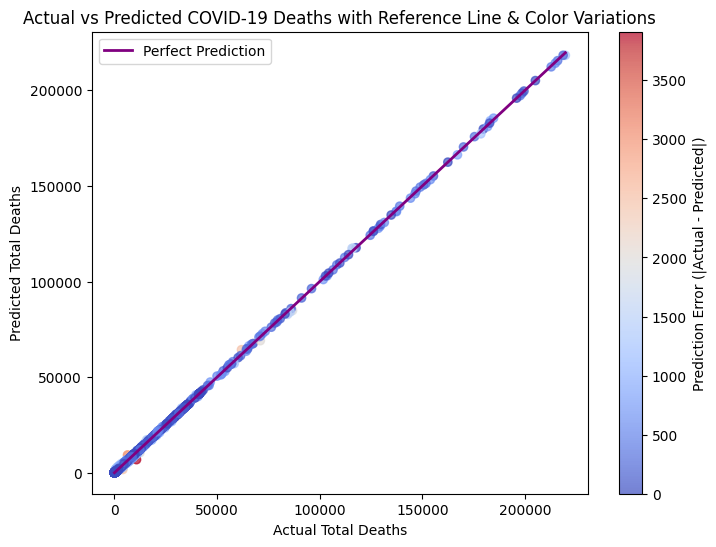

In [ ]:
# Create the scatter plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(y_test, y_pred_final, c=np.abs(y_test - y_pred_final), cmap='coolwarm', alpha=0.7)

# Add a reference line (y = x)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='purple', linestyle='-', linewidth=2, label="Perfect Prediction")

# Add color bar
cbar = plt.colorbar(scatter)
cbar.set_label("Prediction Error (|Actual - Predicted|)")

# Labels and title (Updated for COVID-19 deaths)
plt.xlabel("Actual Total Deaths")
plt.ylabel("Predicted Total Deaths")
plt.title("Actual vs Predicted COVID-19 Deaths with Reference Line & Color Variations")
plt.legend()
plt.show()

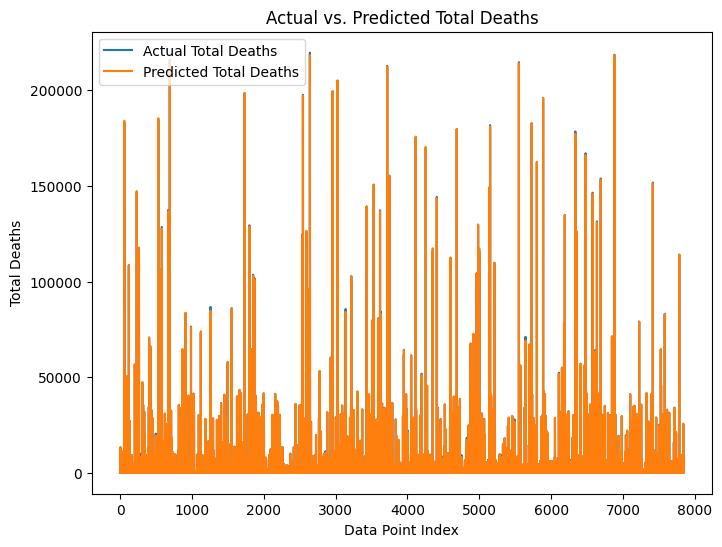

In [ ]:
#Plot graph according to it for total death

plt.figure(figsize=(8, 6))
plt.plot(y_test.values, label='Actual Total Deaths')
plt.plot(y_pred_final, label='Predicted Total Deaths')
plt.xlabel('Data Point Index')
plt.ylabel('Total Deaths')
plt.title('Actual vs. Predicted Total Deaths')
plt.legend()
plt.show()
